In [1]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 4.3 MB/s 
     |████████████████████████████████| 6.6 MB 40.1 MB/s 
     |████████████████████████████████| 895 kB 34.6 MB/s 
     |████████████████████████████████| 77 kB 2.5 MB/s 
     |████████████████████████████████| 596 kB 56.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install nlpaug

     |████████████████████████████████| 410 kB 5.2 MB/s 


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
import numpy as np 
import pandas as pd 
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,matthews_corrcoef

from tqdm import tqdm, trange,tnrange,tqdm_notebook
import random
import os
import io
%matplotlib inline
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [4]:
import torch
torch.cuda.empty_cache()

In [5]:
import gc
gc.collect()

3

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
os.chdir('drive/MyDrive/William_2022')

In [ ]:
!ls

In [8]:
df = pd.read_csv('DATASETS/CSV/full_transcript_concat.csv')

In [9]:
df['arousal_trans'] = df['arousal_trans'].round()
df['arousal2_trans'] = df['arousal2_trans'].round()

df['valence_trans'] = df['valence_trans'].round()
df['valence2_trans'] = df['valence2_trans'].round()

df['happy_trans'] = df['happy_trans'].round()
df['happy2_trans'] = df['happy2_trans'].round()

df['angry_trans'] = df['angry_trans'].round()
df['angry2_trans'] = df['angry2_trans'].round()

df['nervous_trans'] = df['nervous_trans'].round()
df['nervous2_trans'] = df['nervous2_trans'].round()

df['sad_trans'] = df['sad_trans'].round()
df['sad2_trans'] = df['sad2_trans'].round()

In [10]:
df1 = df[['new_words', 'valence2_trans']]

In [11]:
df1['valence2_trans'] = df1['valence2_trans'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df1['label_enc'] = labelencoder.fit_transform(df1['valence2_trans'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
df1['label_enc'].value_counts()

1    1574
2     152
0     131
3       6
Name: label_enc, dtype: int64

In [14]:
df1['valence2_trans'].value_counts()

3    1574
4     152
2     131
5       6
Name: valence2_trans, dtype: int64

In [ ]:
'''
3- very high
2 - high
1- neutral
0 - low
'''

'\n2 - high\n1- neutral\n0 - low\n'

In [15]:
def to_emotion(rating):
  rating = int(rating)
  if rating == 2:
    return 'low'
  elif rating == 4:
    return 'high'
  elif rating == 5:
    return 'very high'
  else: 
    return 'neutral'

df1['valence2_trans'] = df1.valence2_trans.apply(to_emotion)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [16]:
df1['valence2_trans'].value_counts()

neutral      1574
high          152
low           131
very high       6
Name: valence2_trans, dtype: int64

In [17]:
df1.rename(columns={'valence2_trans':'label_desc'},inplace=True)
df1.rename(columns={'label_enc':'label'},inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [18]:
X_train = df1['new_words']

In [19]:
y_train = df1['label']

In [ ]:
X_train

482     for Koreans that we ourselves were officials o...
299     that these refugees can get into and therefore...
266       of Korea issue and I think me to take more care
16      for for Korea being under the UN Refugee Conve...
489     which stated that six people were killed which...
                              ...                        
1625                           they will refuse to employ
243     to sort out rather than just blocking all thos...
321     I'm really glad that you brought into other co...
1104                                    not logical thing
931     they call themselves Muslims so you're saying ...
Name: new_words, Length: 1490, dtype: object

In [20]:
aug = naw.SynonymAug(aug_src='wordnet',aug_max=3)


In [21]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> l
Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
                           Extraction Systems in Biology)
  [ ] bllip_wsj_no_aux.... BLLIP Parser: WSJ Model
  [ ] book_grammars....... Grammars from NLTK Book
  [ ] brown............... Brown Corpus
  [ ] brown_tei........... Brown Corpus (TEI XML Version)
  [ ] cess_cat............ CESS-CAT Treebank
  [

True

In [22]:
y_train.value_counts()

1    1574
2     152
0     131
3       6
Name: label, dtype: int64

In [23]:
augmented_sentences_0=[]
augmented_sentences_labels_0=[]
for i in X_train.index:
  if y_train[i]==3:
    temps=aug.augment(X_train[i],n=262)
    for sent in temps:
      augmented_sentences_0.append(sent)
      augmented_sentences_labels_0.append(3)

In [24]:
augmented_sentences_3=[]
augmented_sentences_labels_3=[]
for i in X_train.index:
  if y_train[i]==0:
    temps=aug.augment(X_train[i],n=11)
    for sent in temps:
      augmented_sentences_3.append(sent)
      augmented_sentences_labels_3.append(0)

In [25]:
augmented_sentences_2=[]
augmented_sentences_labels_2=[]
for i in X_train.index:
  if y_train[i]==2:
    temps=aug.augment(X_train[i],n=9)
    for sent in temps:
      augmented_sentences_2.append(sent)
      augmented_sentences_labels_2.append(2)

In [ ]:
len(augmented_sentences_3)

1020

In [ ]:
len(augmented_sentences_labels_1)

812

In [ ]:
y_train.value_counts()

1    999
2    972
0     19
dtype: int64

In [26]:
X_train=X_train.append(pd.Series(augmented_sentences_0),ignore_index=True)
y_train=y_train.append(pd.Series(augmented_sentences_labels_0),ignore_index=True)

In [27]:
X_train=X_train.append(pd.Series(augmented_sentences_3),ignore_index=True)
y_train=y_train.append(pd.Series(augmented_sentences_labels_3),ignore_index=True)

In [28]:
X_train=X_train.append(pd.Series(augmented_sentences_2),ignore_index=True)
y_train=y_train.append(pd.Series(augmented_sentences_labels_2),ignore_index=True)

In [29]:
X_y = pd.concat([X_train, y_train], axis = 1)

In [30]:
df = X_y

In [32]:
df.rename(columns={0:'new_words'},inplace=True)
df.rename(columns={1:'label'},inplace=True)


In [33]:
df

,new_words,label
0,all right first one the state for this accepti...,1
1,arrived in this especially in many Arab Jesus ...,1
2,Jeju Allah first of all I want to mention that...,1
3,movement in South Korea against against this y...,1
4,pretty much standard phobic activity because,1
...,...,...
6239,if we bottom read that ask me yes I,2
6240,if we can understand that ask maine yes Ace,2
6241,if we ass understand that ask pine tree state ...,2
6242,if we give the sack sympathise that ask maine ...,2


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

SEED = 19

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

In [35]:
device = torch.device("cuda")

In [36]:
sentences = df.new_words.values

In [ ]:
sentences.shape

(3313,)

In [37]:
MAX_LEN = 32

tokenizer = BertTokenizer.from_pretrained('bert-base-cased',do_lower_case=True)
input_ids = [tokenizer.encode(sent, add_special_tokens=True,max_length=MAX_LEN,pad_to_max_length=True) for sent in sentences]
labels = df.label.values

print("Actual sentence before tokenization: ",sentences[2])
print("Encoded Input from dataset: ",input_ids[2])

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Actual sentence before tokenization:  Jeju Allah first of all I want to mention that the current
Encoded Input from dataset:  [101, 179, 21024, 1358, 1155, 3354, 1148, 1104, 1155, 178, 1328, 1106, 4734, 1115, 1103, 1954, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [38]:
attention_masks = []

attention_masks = [[float(i>0) for i in seq] for seq in input_ids]
print(attention_masks[2])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [39]:
#stratified k fold

train_inputs,validation_inputs,train_labels,validation_labels = train_test_split(input_ids,labels,random_state=41,test_size=0.1)
train_masks,validation_masks,_,_ = train_test_split(attention_masks,input_ids,random_state=41,test_size=0.1)

In [40]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

batch_size = 20

train_data = TensorDataset(train_inputs,train_masks,train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

validation_data = TensorDataset(validation_inputs,validation_masks,validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data,sampler=validation_sampler,batch_size=batch_size)

In [42]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4).to(device)

lr = 2e-5
adam_epsilon = 1e-8

epochs = 30
num_warmup_steps = 0
num_training_steps = len(train_dataloader)*epochs

optimizer = AdamW(model.parameters(), lr=lr,eps=adam_epsilon,correct_bias=False)  
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [41]:
df['label'].value_counts()

3    1578
1    1574
0    1572
2    1520
Name: label, dtype: int64

In [43]:

val_accuracy_set = []
val_mcc_set = []
train_loss_set = []
learning_rate = []

df_test = pd.DataFrame()

model.zero_grad()

for _ in tnrange(1,epochs+1,desc='Epoch'):
  print("<" + "="*22 + F" Epoch {_} "+ "="*22 + ">")
  batch_loss = 0

  for step, batch in enumerate(train_dataloader):
    model.train()
    
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    
    loss.backward()
    
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
    optimizer.step()
    
    scheduler.step()

    optimizer.zero_grad()
    
    batch_loss += loss.item()

  avg_train_loss = batch_loss / len(train_dataloader)

  for param_group in optimizer.param_groups:
    print("\n\tCurrent Learning rate: ",param_group['lr'])
    learning_rate.append(param_group['lr'])
    
  train_loss_set.append(avg_train_loss)
  print(F'\n\tAverage Training loss: {avg_train_loss}')
  

  
    
  # Validation


  model.eval()

  eval_accuracy,eval_mcc_accuracy,nb_eval_steps = 0, 0, 0
  
  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = logits[0].to('cpu').numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    
    

    df_metrics=pd.DataFrame({'Epoch':epochs,'Actual_class':labels_flat,'Predicted_class':pred_flat})
    df_test = df_test.append(df_metrics)
    tmp_eval_accuracy = accuracy_score(labels_flat,pred_flat)
    tmp_eval_mcc_accuracy = matthews_corrcoef(labels_flat, pred_flat)
    
    eval_accuracy += tmp_eval_accuracy
    eval_mcc_accuracy += tmp_eval_mcc_accuracy
    nb_eval_steps += 1

  val_accuracy_set.append(eval_accuracy/nb_eval_steps)
  val_mcc_set.append(eval_mcc_accuracy/nb_eval_steps)

  print(F'\n\tValidation Accuracy: {eval_accuracy/nb_eval_steps}')
  print(F'\n\tValidation MCC Accuracy: {eval_mcc_accuracy/nb_eval_steps}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  # This is added back by InteractiveShellApp.init_path()


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

<====================== Epoch 1 ======================>

	Current Learning rate:  1.9333333333333333e-05

	Average Training loss: 0.9486133798797783

	Validation Accuracy: 0.6234375

	Validation MCC Accuracy: 0.5679243585240884
<====================== Epoch 2 ======================>

	Current Learning rate:  1.866666666666667e-05

	Average Training loss: 0.5782119379879317

	Validation Accuracy: 0.8109375

	Validation MCC Accuracy: 0.7690719697432321
<====================== Epoch 3 ======================>

	Current Learning rate:  1.8e-05

	Average Training loss: 0.3599640316333211

	Validation Accuracy: 0.8984374999999999

	Validation MCC Accuracy: 0.8689720750773351
<====================== Epoch 4 ======================>

	Current Learning rate:  1.7333333333333336e-05

	Average Training loss: 0.2130937604565054

	Validation Accuracy: 0.9109374999999998

	Validation MCC Accuracy: 0.8824816852654439
<====================== Epoch 5 ======================>

	Current Learning rate:  1.66

In [49]:
df_test = df_test.iloc[0:len(df)]

In [45]:
validation_accuracy= eval_accuracy/nb_eval_steps
print(validation_accuracy)

0.9515624999999996


In [46]:
mcc = eval_mcc_accuracy/nb_eval_steps
print(mcc)

0.9347656573884543


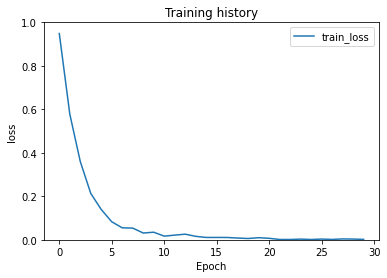

In [50]:
plt.plot(train_loss_set, label='train_loss')


plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

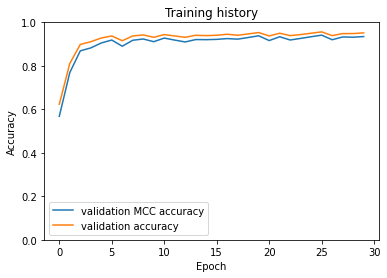

In [51]:
plt.plot(val_mcc_set, label='validation MCC accuracy')
plt.plot(val_accuracy_set, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
len(input_ids)

3313

In [52]:
from sklearn.metrics import confusion_matrix,classification_report
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
labels_flat

array([1, 1, 0, 2, 2, 2, 0])

In [53]:
cm = confusion_matrix(df_test['Actual_class'].values, df_test['Predicted_class'].values)

In [54]:
cm

array([[1421,   29,   69,    0],
       [ 127, 1106,  393,    3],
       [   6,  101, 1368,    2],
       [   0,    0,    0, 1619]])

Confusion matrix, without normalization
[[1421   29   69    0]
 [ 127 1106  393    3]
 [   6  101 1368    2]
 [   0    0    0 1619]]


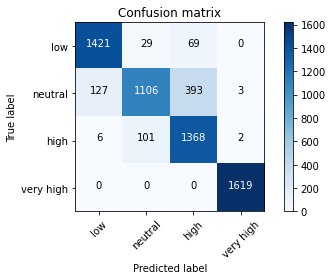

In [56]:
plot_confusion_matrix(cm, ['low', 'neutral', 'high', 'very high'])

In [ ]:
df[['label','label_desc']].drop_duplicates(keep='first')

KeyError: ignored

In [ ]:
df_metrics

,Epoch,Actual_class,Predicted_class
0,10,1,1
1,10,1,1
2,10,0,1
3,10,2,1
4,10,2,1
5,10,2,1
6,10,0,1


In [ ]:
df1['label'].value_counts()

1    1452
2     239
0     172
Name: label, dtype: int64

In [ ]:
df_test

,Epoch,Actual_class,Predicted_class
0,30,1,0
1,30,0,2
2,30,2,0
3,30,2,2
4,30,0,0
...,...,...,...
2,30,2,2
3,30,0,0
4,30,1,1
5,30,0,0


In [ ]:
df['Predicted_class'].value_counts()

1    4270
Name: Predicted_class, dtype: int64

In [58]:
df1['label'].value_counts()

1    1574
2     152
0     131
3       6
Name: label, dtype: int64

In [61]:
label2int = {
  
  "neutral": 1,
  "low": 0,
  'high': 2,
  'very high' : 3
}

In [62]:
print(classification_report(df_test['Actual_class'].values, df_test['Predicted_class'].values, target_names=label2int.keys(), digits=len(label2int)))

              precision    recall  f1-score   support

     neutral     0.9144    0.9355    0.9248      1519
         low     0.8948    0.6789    0.7721      1629
        high     0.7475    0.9262    0.8273      1477
   very high     0.9969    1.0000    0.9985      1619

    accuracy                         0.8831      6244
   macro avg     0.8884    0.8852    0.8807      6244
weighted avg     0.8912    0.8831    0.8810      6244



In [ ]:
!ls

'CMU SAIL LITERATURE LECTURES.gsheet'  'Meeting Notes.gdoc'
 DATASETS			       'RESEARCH NOTES.gdoc'


In [63]:

model.save_pretrained('DATASETS')
#tokenizer.save_pretrained('DATASETS')

model_save_name = 'valence2_fineTuneModel_aug_30epoch.pt'
path = path_model = F'{model_save_name}'
torch.save(model.state_dict(),path)